## Remap Series 1: Do Mountainsort

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting as ss

from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.helpers import interval_union

[2023-10-09 00:19:16,953][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-10-09 00:19:16,975][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


### Specify date

In [3]:
nwb_copy_file_name = "molly20220416_.nwb"

In [4]:
IntervalList_pd=pd.DataFrame(IntervalList & {'nwb_file_name': nwb_copy_file_name})
interval_pd=pd.DataFrame((TaskEpoch & {'nwb_file_name':nwb_copy_file_name}).fetch())
interval_pd.insert(5, "pos_name", '')

# select position timestamps, only maze sessions or sleep are selected
for i in IntervalList_pd.index:
    interval=IntervalList_pd['interval_list_name'][i]
    if interval[0:3]=='pos':
        interval_pd.loc[int(interval[4:6]),'pos_name']=interval

#position_interval=interval_pd.pos_name #use this line if needed
session_interval=[]
position_interval=[]
for i in interval_pd.index:
    if interval_pd.loc[i,"task_name"]=="maze":
        session_interval.append(interval_pd.loc[i,"interval_list_name"])
        position_interval.append(interval_pd.loc[i,"pos_name"])

In [5]:
session_interval

['02_Seq2Session1',
 '04_Seq2Session2',
 '06_Seq2Session3',
 '08_Seq2Session4',
 '10_Seq2Session5']

In [6]:
position_interval

['pos 1 valid times',
 'pos 3 valid times',
 'pos 5 valid times',
 'pos 7 valid times',
 'pos 9 valid times']

### Specify Mountainsort parameters

In [7]:
# Let's look at the default params
sorter_name = "mountainsort4"
ms4_default_params = (
    ss.SpikeSorterParameters
    & {"sorter": sorter_name, "sorter_params_name": "default"}
).fetch1()
print(ms4_default_params)

{'sorter': 'mountainsort4', 'sorter_params_name': 'default', 'sorter_params': {'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}}


In [8]:
## Change default
sorter_params = {
    **ms4_default_params["sorter_params"],  # start with defaults
    "filter": False,  # No filter, since we filter prior to starting sort
    "freq_min": 0,
    "freq_max": 0,
    "whiten": False,  # Turn off whiten, since we whiten it prior to starting sort
    "num_workers": 4,  #  same number as number of electrodes
    "verbose": True,
    "clip_size": np.int64(
        1.33e-3  # same as # of samples for 1.33 ms based on the sampling rate
        * (Raw & {"nwb_file_name": nwb_copy_file_name}).fetch1("sampling_rate")
    ),
}


pprint(sorter_params)

{'adjacency_radius': -1,
 'clip_size': 39,
 'detect_interval': 10,
 'detect_sign': -1,
 'detect_threshold': 3,
 'filter': False,
 'freq_max': 0,
 'freq_min': 0,
 'num_workers': 4,
 'verbose': True,
 'whiten': False}


In [9]:
sorter_params_name = "CA1_tet_Shijie"
ss.SpikeSorterParameters.insert1(
    {"sorter": sorter_name,"sorter_params_name": sorter_params_name,"sorter_params": sorter_params},
    skip_duplicates=True)

In [10]:
ss.SpikeSorterParameters & {"sorter": sorter_name,
                          "sorter_params_name": sorter_params_name}

sorter,sorter_params_name,sorter_params
mountainsort4,CA1_tet_Shijie,=BLOB=


In [67]:
SpikeSortingSelection & {"nwb_file_name": nwb_copy_file_name,'sorter': 'mountainsort4'}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,import_path optional path to previous curated sorting output


### Specify time interval

In [11]:
def sort(sort_interval_name):
    artifact_params_name='ampl_100_prop_05_2ms'
    #sort_interval_name='04_Seq2Session2'

    artifact_key=(ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name} 
                              & {'artifact_params_name': artifact_params_name}
                              & {'sort_interval_name':sort_interval_name})
    # fetch, and there should be 2 entries, one from left cannula (group 100), and one from right cannula (group 101)
    artifact_removed_name_list=artifact_key.fetch('artifact_removed_interval_list_name')
    assert len(artifact_removed_name_list)==2

    artifact_time_list=[]
    artifact_removed_time_list=[]
    for artifact_removed_name in artifact_removed_name_list:
        artifact_time_list.append((ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name,'artifact_removed_interval_list_name':artifact_removed_name}).fetch1('artifact_times'))
        artifact_removed_time_list.append((IntervalList() & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':artifact_removed_name}).fetch1('valid_times'))

    artifact_time_list=interval_union(artifact_time_list[0],artifact_time_list[1])
    artifact_removed_time_list=interval_list_intersect(
        np.array(artifact_removed_time_list[0]),np.array(artifact_removed_time_list[1]))
    
    # find tetrodes
    tetrode_with_cell=np.unique((SpikeSortingRecordingSelection & {'nwb_file_name':nwb_copy_file_name}).fetch('sort_group_id'))
    tetrode_with_cell=np.setdiff1d(tetrode_with_cell,[100,101])
    
    # insert into individual tetrodes ArtifactRemovedIntervalList
    artifact_params_name='ampl_1500_prop_075_1ms'
    sorting_keys=[]
    for tetrode in tetrode_with_cell:
        print(tetrode,sort_interval_name)
        artifact_key = {'nwb_file_name' : nwb_copy_file_name,
                    'sort_interval_name' : sort_interval_name,
                    'sort_group_id' : tetrode,
                    'preproc_params_name': 'franklab_tetrode_hippocampus',
                    'team_name': 'Shijie Gu'}       #SequenceTask
        artifact_key['artifact_params_name'] = artifact_params_name

        ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)

        artifact_key['artifact_times']=artifact_time_list
        artifact_key['artifact_removed_valid_times']=artifact_removed_time_list

        artifact_name=(nwb_copy_file_name+'_'+sort_interval_name+'_'+str(artifact_key['sort_group_id'])+'_'+
                       artifact_key['preproc_params_name']+'_'+artifact_params_name+'_artifact_removed_valid_times')

        artifact_key['artifact_removed_interval_list_name']=artifact_name

        ArtifactRemovedIntervalList().insert1(artifact_key,skip_duplicates=True)

        IntervalList().insert1({'nwb_file_name' : nwb_copy_file_name,
                               'interval_list_name':artifact_name,
                               'valid_times':artifact_removed_time_list},skip_duplicates=True)

        artifact_key.pop('artifact_params_name')
        artifact_key.pop('artifact_times')
        artifact_key.pop('artifact_removed_valid_times')

        artifact_key['sorter'] = sorter_name
        artifact_key['sorter_params_name'] = sorter_params_name

        SpikeSortingSelection.insert1(artifact_key, skip_duplicates=True)

        sorting_keys.append(artifact_key.copy())
    
    # populate
    SpikeSorting.populate({'nwb_file_name':nwb_copy_file_name,
                    'artifact_params_name': artifact_params_name, # make sure to inlude this
                    'sort_interval_name':sort_interval_name})
    return sorting_keys

In [ ]:
for session_ind in range(len(session_interval)):
    
    session=session_interval[session_ind]
    print('session',session)
    '''
    detect spikes
    '''
    sorting_keys=sort(session)

session 02_Seq2Session1
0 02_Seq2Session1
2 02_Seq2Session1
3 02_Seq2Session1
6 02_Seq2Session1
7 02_Seq2Session1
9 02_Seq2Session1
10 02_Seq2Session1
12 02_Seq2Session1
15 02_Seq2Session1
17 02_Seq2Session1
18 02_Seq2Session1
25 02_Seq2Session1
27 02_Seq2Session1
28 02_Seq2Session1
34 02_Seq2Session1
37 02_Seq2Session1
39 02_Seq2Session1
40 02_Seq2Session1
41 02_Seq2Session1
43 02_Seq2Session1
46 02_Seq2Session1
50 02_Seq2Session1
52 02_Seq2Session1
53 02_Seq2Session1
55 02_Seq2Session1
60 02_Seq2Session1
61 02_Seq2Session1
62 02_Seq2Session1
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.94.1.dev0
Running spike sorting on {'nwb_file_name': 'molly20220416_.nwb', 'sort_group_id': 7, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'mountainsort4', 'sorter_params_name': 'CA1_tet_Shijie', 'artifact_removed_interval_list_name': 'molly20220416_.nwb_02_Seq2Session1_7_frank

In [ ]:
SpikeSorting & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}

### Insertion into Curation and CuratedSpikeSorting to allow metric calculation

In [ ]:
entries=(SpikeSorting & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}).fetch(as_dict=True)
curation_keys=[]
for e in entries:
    e.pop('sorting_path')
    e.pop('time_of_sort')
    curation_keys.append(Curation.insert_curation(e))
    

In [ ]:
Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}

In [ ]:
curation_keys=(Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}).fetch("KEY")
CuratedSpikeSortingSelection().insert(curation_keys,skip_duplicates=True)

In [ ]:
CuratedSpikeSorting.populate(CuratedSpikeSortingSelection() & curation_keys)

In [ ]:
(CuratedSpikeSorting & {"nwb_file_name": nwb_copy_file_name,
                      "sort_interval_name": session_interval[0],"sorter":"mountainsort4"})

### Waveform Table and Metric tables to calculate metrics for excluding noise

In [ ]:
curation_keys=(Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4",}).fetch("KEY")
for d in curation_keys:
    d["waveform_params_name"]="default_clusterless"
WaveformSelection.insert(curation_keys)

In [ ]:
Waveforms.populate(curation_keys)

In [ ]:
Waveforms & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4",}

In [ ]:
waveforms_keys=(Waveforms & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4",}).fetch("KEY")
for d in waveforms_keys:
    d["metric_params_name"]="franklab_default3"
MetricSelection.insert(waveforms_keys,skip_duplicates=True)

In [ ]:
session_interval

In [ ]:
for k in waveforms_keys:
    try:
        QualityMetrics.populate(k)
    except:
        print('error',k)

In [26]:
QualityMetrics & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,waveform_params_name name of waveform extraction parameters,metric_params_name,quality_metrics_path,analysis_file_name name of the file,object_id Object ID for the metrics in NWB file
0,molly20220416_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_6035707e_0_default_clusterless_waveforms_qm.json,molly20220416_UZFU8VL32H.nwb,8bcbebd8-20a1-4c91-9623-0743784aa558
0,molly20220416_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_a2f0f7c3_0_default_clusterless_waveforms_qm.json,molly20220416_SQNTK1R8E8.nwb,79d94237-ed43-4652-9cef-35885501382f
0,molly20220416_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_4dcbce9c_0_default_clusterless_waveforms_qm.json,molly20220416_4PW9FW157S.nwb,ae6844b0-9a4f-4bc9-8648-cc529c5c94ae
0,molly20220416_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_5b48cf72_0_default_clusterless_waveforms_qm.json,molly20220416_4P7VQC300F.nwb,3588622b-ba59-46cd-b9a1-ddfa6cb5efee
0,molly20220416_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_f8a5c1a9_0_default_clusterless_waveforms_qm.json,molly20220416_1BJGHU7W9O.nwb,762cd561-388d-4447-b8ed-7cd494eb6dfa
0,molly20220416_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_1ba8cdec_0_default_clusterless_waveforms_qm.json,molly20220416_0AYP4CS21F.nwb,b0226769-3541-4a6c-bf10-5462398c749d
0,molly20220416_.nwb,2,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_98b4c366_0_default_clusterless_waveforms_qm.json,molly20220416_AIJ5RBIZ44.nwb,fb549a30-bce3-4a55-9342-591e4072f530
0,molly20220416_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,franklab_default3,/stelmo/nwb/waveforms/molly20220416_.nwb_d0aa1bb9_0_default_clusterless_waveforms_qm.json,molly20220416_YPT3EW967S.nwb,312b7a77-27d3-401b-882c-3af8a540a87f
0,molly20220416_.nwb,2,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,molly20220416_.nwb_08_Seq2Session4_2_franklab_tetrode_hippocampus_ampl_15

In [ ]:
END HERE

### For one session: 
##### 1) remove noise units
##### 2) find peak amp
##### 3) make spray window

In [267]:
session_key = {"nwb_file_name": nwb_copy_file_name,
                  "sorter":"mountainsort4",
                  "sort_interval_name":"02_Seq2Session1",
                  "sort_group_id":14}

In [268]:
session_key = (QualityMetrics & session_key).fetch1("KEY")

'''
load metric
'''
metrics_json_path=(QualityMetrics & session_key).fetch1("quality_metrics_path")
# Opening JSON file
with open(metrics_json_path) as json_file:
    metrics_json = json.load(json_file)
    
'''
load extractor and waveform into dict called waves
'''
we = Waveforms.load_waveforms(Waveforms,session_key) #extractor

nwb_units = (CuratedSpikeSorting() & session_key).fetch_nwb()[0]["units"]
peak_sign = "neg"

wave=UnitMarks._get_peak_amplitude(
        waveform=we.get_waveforms(1),
        peak_sign="neg",
        estimate_peak_time=True) ## load waveform

waves={}
for unit_id in nwb_units.index:
    wave=UnitMarks._get_peak_amplitude(
        waveform=we.get_waveforms(unit_id),
        peak_sign="neg",
        estimate_peak_time=True)
    timestamps = np.asarray(nwb_units["spike_times"][unit_id])
    sorted_timestamp_ind = np.argsort(timestamps)
    marks = wave[sorted_timestamp_ind]
    timestamps = timestamps[sorted_timestamp_ind]

    waves[unit_id]=marks

snr = metrics_json['snr']
accepted_units=[unit_id for unit_id in nwb_units.index if snr[str(unit_id)]>=20]
print('Accepted units: ', accepted_units)

In [258]:
pair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]  #tetrode channel pairs
color_palet = 1-np.array([[1,0.6,0],[0.7,0.6,0.4],[0.6,0.8,0.3],
                          [0,0.6,.3],[0,0,1],[0,0.6,1],[0,0.7,0.7],
                          [0.7,0,0.7],[0.7,0.4,1]]);
color_palet = color_palet[np.concatenate((np.arange(0,9,2),np.arange(1,9,2)))] # scramble slightly

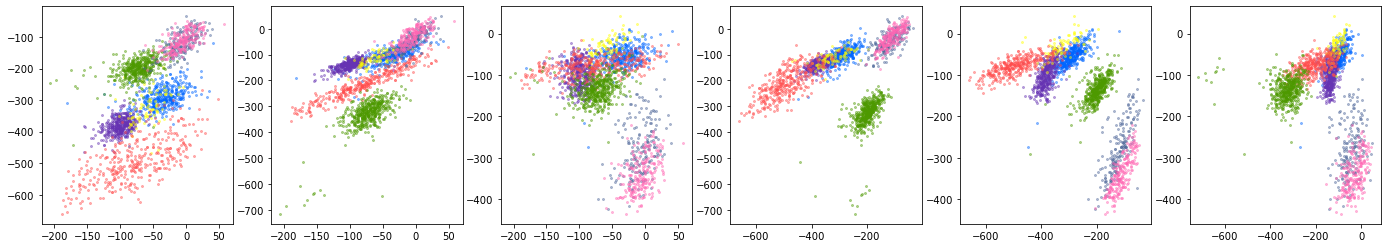

In [261]:
fig,axes=plt.subplots(1,6,figsize=(24,4))

## get amplitude
color_ind=0
for u in accepted_units:
    for p in range(6):
        e1,e2=pair[p]
        axes[p].scatter(waves[u][:,e1],waves[u][:,e2], color=color_palet[color_ind], s=4,alpha = 0.4)
    color_ind = (color_ind+1) % color_palet.shape[0]

### Below are something for figurl

In [73]:
    '''
    populate UnitMarks table
    '''
    mark_parameters_keys = pd.DataFrame(CuratedSpikeSorting & curation_keys)
    mark_parameters_keys['mark_param_name'] = 'default'
    mark_parameters_keys = (mark_parameters_keys
                            .loc[:, UnitMarkParameters.primary_key]
                            .to_dict('records'))
    UnitMarkParameters().insert(
        mark_parameters_keys,
        skip_duplicates=True)
    
    UnitMarks.populate(UnitMarkParameters & mark_parameters_keys)

[2023-09-29 20:51:01,717][WARNING]: Skipped checksum for file with hash: 988f72ef-29b3-bdaa-e942-adf693765fee, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_NKD46ZH1FT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_7D4GY3MVYH.nwb


[2023-09-29 20:51:12,335][WARNING]: Skipped checksum for file with hash: 6b948148-32e3-05ea-9503-cd81e3d6f457, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_F240XU48US.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_MQ9WKD1MQL.nwb


[2023-09-29 20:51:20,767][WARNING]: Skipped checksum for file with hash: caaf60ac-5607-74fa-4d5f-c29f19647eee, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_RTLXSG1RWG.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_4GWSPOS9MZ.nwb


[2023-09-29 20:51:29,452][WARNING]: Skipped checksum for file with hash: 07b9a43f-a4ca-fd97-6103-af751f289490, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_SG2IFMTOPX.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_9MPCO5L8U1.nwb


[2023-09-29 20:51:37,539][WARNING]: Skipped checksum for file with hash: 1ae23b90-40ba-f2da-2fbe-b5cb56c4eebf, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VI97TQTVU9.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_76DHV729LO.nwb


[2023-09-29 20:51:52,464][WARNING]: Skipped checksum for file with hash: b64441f3-56bf-43b9-28a5-69e581a11882, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CXICU6WL3T.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_7YWLTFH2L0.nwb


[2023-09-29 20:52:02,816][WARNING]: Skipped checksum for file with hash: c2c5c03f-1648-3dfd-6b3b-ca8d40e9b40f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FM7EX9QRIB.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_A37AX3K45C.nwb


[2023-09-29 20:52:10,418][WARNING]: Skipped checksum for file with hash: 7d8bc6a3-8f30-5b33-dd40-f3213cd235f7, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_C8SJY6CCJO.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_NFNM4V1NJ6.nwb


[2023-09-29 20:52:18,108][WARNING]: Skipped checksum for file with hash: f45e712c-ca52-2574-4556-30f3b4110139, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_RZ5T1O6KS7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_N9I484O0O2.nwb


[2023-09-29 20:52:25,372][WARNING]: Skipped checksum for file with hash: d6ad3536-c002-2763-7f1e-c8e5a020b068, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_AVKCY3ME85.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SLBL8Z4M6E.nwb


[2023-09-29 20:52:38,533][WARNING]: Skipped checksum for file with hash: ac541217-6ec9-082f-e6f4-22d35cbce6cd, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IYRKWTSM8R.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_UZCQPJBMKM.nwb


[2023-09-29 20:52:47,084][WARNING]: Skipped checksum for file with hash: dae03ca9-efc0-052b-6a01-a42d48befcb8, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1WS7DO9ZXH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_1YV5JH6Z00.nwb


[2023-09-29 20:52:54,885][WARNING]: Skipped checksum for file with hash: 5cdff2db-214b-3a2a-8a62-49809d6db42b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JYG6UICU6V.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_HFTXRRB60E.nwb


[2023-09-29 20:53:02,342][WARNING]: Skipped checksum for file with hash: 2eb60337-b94e-a5d9-5dae-c826514ff13e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_NA5Z3GLNY6.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_DM2B5IKWUY.nwb


[2023-09-29 20:53:09,379][WARNING]: Skipped checksum for file with hash: b40f4904-6904-a6c9-37e8-67696f96437b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_3IGRISFRXU.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ATJ17GNDG6.nwb


[2023-09-29 20:53:21,784][WARNING]: Skipped checksum for file with hash: d0a66d4d-8a8f-c64b-74d1-5e31f8ce0c10, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_99JU8IZWTD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_LA9CLB5B9R.nwb


[2023-09-29 20:53:31,337][WARNING]: Skipped checksum for file with hash: 4a23bedb-93ad-6ca8-e632-0365f2c3e8c1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_11KEQ1I5M8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_FBUDG3IWHO.nwb


[2023-09-29 20:53:40,343][WARNING]: Skipped checksum for file with hash: 67d29020-f679-d994-8d46-b96f89e56d48, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_BTF3YJ7UHN.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_CYESFF5E47.nwb


[2023-09-29 20:54:50,672][WARNING]: Skipped checksum for file with hash: 6086b28b-cf25-2789-becf-f7be63b90633, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VRS7KUDRCI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_APFO58H3AE.nwb


[2023-09-29 20:56:10,039][WARNING]: Skipped checksum for file with hash: b6fa702e-6f83-999e-a5a1-a00b3a77149e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4XK2LCMKJL.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_9Z721S1NWW.nwb


[2023-09-29 20:56:32,484][WARNING]: Skipped checksum for file with hash: 9b073e7b-86b4-f426-4608-e9cbe9e2518a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DDS4RV02RI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_G03ECHO5I6.nwb


[2023-09-29 20:56:45,537][WARNING]: Skipped checksum for file with hash: ff5d4016-31a8-b775-f491-bc20e7aa4b08, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PEEDTLHXFE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_JR68IVRL1Q.nwb


[2023-09-29 20:56:54,464][WARNING]: Skipped checksum for file with hash: 10e20922-aac0-bd2a-832f-0781de14daa8, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KGNKWDSWBI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_FT5EQINAAB.nwb


[2023-09-29 20:57:11,901][WARNING]: Skipped checksum for file with hash: 5a18b2af-14a7-16ba-799b-90c0733e07ca, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_XYFRXBFDHM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_3V5LFFIBIW.nwb


[2023-09-29 20:57:20,978][WARNING]: Skipped checksum for file with hash: 08f957e5-5e25-5c03-9188-64d82e256130, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_Q0BVYIHQ4X.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ANHRZL5QS2.nwb


[2023-09-29 20:58:47,750][WARNING]: Skipped checksum for file with hash: e508afeb-5105-1723-729e-ec702d819bc5, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GEPNLYUZS7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_GH8VATCBUO.nwb


[2023-09-29 20:59:31,627][WARNING]: Skipped checksum for file with hash: 57073f5e-a0c4-0831-b87f-e74ede01be18, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_Q7TXNVBSCX.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_IGJZKZOADF.nwb


[2023-09-29 20:59:42,492][WARNING]: Skipped checksum for file with hash: c717d3db-7d0c-18be-71d3-1be92c6be81f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_TCH1QKWZPS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_YB1Q5HXLGF.nwb


[2023-09-29 20:59:56,078][WARNING]: Skipped checksum for file with hash: 15082797-e458-a369-0f68-a4d495af07e8, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_OMIBXYRLAT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_05W8L5107P.nwb


[2023-09-29 21:00:09,555][WARNING]: Skipped checksum for file with hash: 88ce8993-3bc4-20e5-8746-5f58d69ae687, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_SWO5ML4YEA.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_6WFRMJ8N3R.nwb


[2023-09-29 21:00:29,131][WARNING]: Skipped checksum for file with hash: 93aeac61-6d98-b9f7-9d2a-af4140fdbadf, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_N2B9SPBHXH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_E4G9TCBK79.nwb


[2023-09-29 21:00:45,713][WARNING]: Skipped checksum for file with hash: ebb1e288-fee9-16c6-e555-a73e1d92862e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_7EF1VCKWAD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_T3N1C98D2Y.nwb


[2023-09-29 21:00:55,033][WARNING]: Skipped checksum for file with hash: 20fb438c-dede-0212-f2ee-f43966e7c141, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KRX6RV6VBW.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_DA6DEYJBSA.nwb


[2023-09-29 21:01:12,139][WARNING]: Skipped checksum for file with hash: 3cc803f5-71b5-dbc2-0138-a61afdfef6a5, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VI7M3L7F4G.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_8TI2S2V1UL.nwb


[2023-09-29 21:01:33,223][WARNING]: Skipped checksum for file with hash: 10b621a2-66da-7d1e-696a-f6b3bcec9aed, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PSJDQ88HM1.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_A4RTL3FQ2A.nwb


[2023-09-29 21:01:51,341][WARNING]: Skipped checksum for file with hash: 9ef0315a-90d0-1dc1-6831-759cb71c8ab3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EH8GAIPZMC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_JOAWC10AYN.nwb


[2023-09-29 21:02:00,636][WARNING]: Skipped checksum for file with hash: 2f9df0aa-0bc5-cf20-9021-2f60fb3212b2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_U302I9QCRY.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_UOXNP9C6JS.nwb


[2023-09-29 21:02:14,046][WARNING]: Skipped checksum for file with hash: 1d45b7a4-204b-0ff3-6a51-e6f487e420a2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CXHCWO9WQT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_M9EECRET0E.nwb


[2023-09-29 21:02:23,255][WARNING]: Skipped checksum for file with hash: a5348c65-f306-ea81-ccd0-78ce18f3e2ba, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QYZAT0S6YF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_IGRVZW3ER8.nwb


[2023-09-29 21:02:42,305][WARNING]: Skipped checksum for file with hash: b538ac54-3e9a-0803-c6cf-e28e41ee4d30, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KYV5QU4SJJ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_VIN2DTV9UO.nwb


[2023-09-29 21:03:02,395][WARNING]: Skipped checksum for file with hash: 09270adf-2429-5c9d-ebf7-006ee5d45783, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_S5B64MQZ1T.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_L5SX8V8QS9.nwb


[2023-09-29 21:03:11,966][WARNING]: Skipped checksum for file with hash: 53e98381-ec5e-6ff4-9cee-9fa3246c3733, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_BDO7INZGDH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_IQUY9LXHV8.nwb


[2023-09-29 21:03:34,296][WARNING]: Skipped checksum for file with hash: 1a9e1b0e-10df-304d-f305-162e35ed382c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_9NSI2HDYFM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_5KFCUQYZPS.nwb


[2023-09-29 21:03:44,575][WARNING]: Skipped checksum for file with hash: 41a61845-ce12-e55a-dd2c-09caa0cfa9a3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GLRTGXBBUZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_TOLUJMR3VG.nwb


[2023-09-29 21:04:02,593][WARNING]: Skipped checksum for file with hash: 559acf94-4f66-4fe4-f621-1928615ee51e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_N3KFW3BESA.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SPJCM7XIFB.nwb


[2023-09-29 21:04:20,499][WARNING]: Skipped checksum for file with hash: f588249f-dfa1-68f6-1523-e410fbf76ce9, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_267LY4J8GT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_HJVS58LA9R.nwb


[2023-09-29 21:04:29,372][WARNING]: Skipped checksum for file with hash: 64419217-584a-d124-177c-61ff3e1f8127, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VRB1P3U52B.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_KJOMM19S6I.nwb


[2023-09-29 21:04:46,697][WARNING]: Skipped checksum for file with hash: fe2b1820-876d-0d89-2998-5ddf5d5d02f9, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JIVZEYQMJL.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_DL6WL5FO5P.nwb


[2023-09-29 21:04:55,327][WARNING]: Skipped checksum for file with hash: 6eee20c2-8b41-30de-f60a-1b350bf88e01, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_58HD911X4P.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_0U2XKZTSMT.nwb


[2023-09-29 21:05:11,290][WARNING]: Skipped checksum for file with hash: 4ab9184a-b9d4-551e-be04-7f8e520530fa, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_YJVG6QOKN6.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ZTCIOEE3O1.nwb


[2023-09-29 21:05:25,875][WARNING]: Skipped checksum for file with hash: 48018cf0-f868-d803-0eb0-e1734001397a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_V5BEF65UHH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_GSNCZRVQ4D.nwb


[2023-09-29 21:05:35,137][WARNING]: Skipped checksum for file with hash: 015d2153-616f-7db5-c4b8-c11c9db03334, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_48S287VWI4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_F2MS92VVYX.nwb


[2023-09-29 21:05:44,005][WARNING]: Skipped checksum for file with hash: de64a7e0-add8-94a5-acfd-1e5b48b3f64c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_W2TSSV678L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_JY9WYXHFTE.nwb


[2023-09-29 21:06:01,295][WARNING]: Skipped checksum for file with hash: 0217c6ad-3590-725b-f412-65446dbbc3ff, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EQZ6X6D53D.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_7QQHAOWMHZ.nwb


[2023-09-29 21:06:18,670][WARNING]: Skipped checksum for file with hash: ecc02f04-a2c7-5467-69cf-bd13be64d405, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UIFPB088PF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_914Q0Z2LSV.nwb


[2023-09-29 21:06:33,509][WARNING]: Skipped checksum for file with hash: 78e33220-bb9e-d2e3-45f7-ffeaa03940c3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_L4EBZ26P73.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_1Y2GG82CPE.nwb


[2023-09-29 21:06:41,886][WARNING]: Skipped checksum for file with hash: f6d5a8fb-e8b1-53ea-8485-74df36351658, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_J6KVOQYQK4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_1EF55BQ6AZ.nwb


[2023-09-29 21:06:49,707][WARNING]: Skipped checksum for file with hash: 785b34d5-7be3-5998-6ecd-634dfe90bf57, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VJJR8B53JS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_T1PCQ9ABEE.nwb


[2023-09-29 21:07:05,739][WARNING]: Skipped checksum for file with hash: f24c154a-bdd6-9c1d-84ee-465c52382aa3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_3L2VP16K1L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ET6O9PQ3GV.nwb


[2023-09-29 21:07:21,796][WARNING]: Skipped checksum for file with hash: 6b42f92a-8a5a-e844-c174-fbd1a4f9bf0c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_564L2SWMFH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_Q55EVWVTRP.nwb


[2023-09-29 21:07:35,589][WARNING]: Skipped checksum for file with hash: 6e42a444-f2c4-a356-5ede-1121da5f8b5f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_5RM0WQ740M.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_4MEP8DUCVL.nwb


[2023-09-29 21:07:44,047][WARNING]: Skipped checksum for file with hash: d93f8720-d3ef-7c0d-c422-f60aa1af17c0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UUFUNX4T47.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_2HTFODTQSU.nwb


[2023-09-29 21:08:00,637][WARNING]: Skipped checksum for file with hash: 13840ed7-5615-f009-9cc0-e92841a3692d, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PDK8X6U2XZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_CAI1KXCY1E.nwb


[2023-09-29 21:08:16,467][WARNING]: Skipped checksum for file with hash: 237b98fa-e60f-5f91-df4a-46c4a86b1534, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EU9KMD506R.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_K8RZV8BAUU.nwb


[2023-09-29 21:08:32,281][WARNING]: Skipped checksum for file with hash: f9d14473-1412-8b1e-7eb9-792141b2a431, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_E81KGRE2K7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SKLWFOB1FX.nwb


[2023-09-29 21:08:47,266][WARNING]: Skipped checksum for file with hash: ea582fc3-cf03-6a82-2050-a024b0f7bcec, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QFCB1VGM0L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_2T4ACN42GU.nwb


[2023-09-29 21:09:06,015][WARNING]: Skipped checksum for file with hash: 60bdb790-3a8f-5de7-34f6-6737845a1e0a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_P0I97UCF69.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_EG16KNNQAF.nwb


[2023-09-29 21:09:14,706][WARNING]: Skipped checksum for file with hash: 32447a4c-6b64-8f69-0d5b-04d84b5eb814, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_ZHB46VSRIU.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_4XJ08YZWSV.nwb


[2023-09-29 21:09:32,150][WARNING]: Skipped checksum for file with hash: 174be5b0-709d-6883-c512-0b266b60f88d, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_D39JW3XXH0.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_AO5P506GSD.nwb


[2023-09-29 21:09:48,590][WARNING]: Skipped checksum for file with hash: 8a387d02-24de-0ef4-5d27-3d24666ce738, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_Q96WJJSNJM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_R5KCW658ZP.nwb


[2023-09-29 21:10:08,716][WARNING]: Skipped checksum for file with hash: 558ff6fd-3c8d-204a-0e8d-200ee96f2091, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_LJGF02PKHD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_HSZDZPFPLB.nwb


[2023-09-29 21:10:29,995][WARNING]: Skipped checksum for file with hash: 0f323274-c49f-2a02-dba7-a55f32285018, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KR04WC3A80.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_950FWZMHMW.nwb


[2023-09-29 21:10:39,500][WARNING]: Skipped checksum for file with hash: ff427324-82d8-aa0a-576f-6d5f1f7d0d19, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PP6OZKK305.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_FNZ2FS6QJA.nwb


[2023-09-29 21:10:54,245][WARNING]: Skipped checksum for file with hash: 16dd0bfc-4472-35ce-b7dc-161ba5ca17f4, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QEKATJZPFR.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_MYB5CTVNKI.nwb


[2023-09-29 21:11:09,516][WARNING]: Skipped checksum for file with hash: be8acc86-2184-18df-1776-9f2929d2d03f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1QOBR98QXG.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SAK2I4T1HP.nwb


[2023-09-29 21:11:23,409][WARNING]: Skipped checksum for file with hash: d087ad54-957d-5d1f-7187-dc29470ca0d0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_D6MEWWXCMC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_TAOFCUEG8R.nwb


[2023-09-29 21:11:39,525][WARNING]: Skipped checksum for file with hash: 28a2dc2b-9afb-2375-de2f-a9195ad6795e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GKPMJ5XK6D.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_U1HRAOYRGR.nwb


[2023-09-29 21:11:47,513][WARNING]: Skipped checksum for file with hash: 8f6cf9ff-747f-8dc1-f51c-5b2d2a0de8df, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_5H7ICBCXAJ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_8A677O9VDV.nwb


[2023-09-29 21:12:03,168][WARNING]: Skipped checksum for file with hash: 4002e523-44a2-c8c0-13da-cb1783b5b5fb, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_441LXJNJU7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_NFORB43QL4.nwb


[2023-09-29 21:12:10,732][WARNING]: Skipped checksum for file with hash: 236b5490-0073-69fc-5b2f-37e909f0f2ca, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QC543LWVBF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_5J1KJ8E8J9.nwb


In [144]:
key={"nwb_file_name": nwb_copy_file_name,"sort_group_id":14,
             "sort_interval_name": session_interval[0],"sorter":"mountainsort4"}
UnitMarks & key

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,analysis_file_name name of the file,marks_object_id the NWB object that stores the marks
0,eliot20221022_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_GH8VATCBUO.nwb,3e8a5665-fb96-4a8b-b36b-4bf6bb260d95


In [145]:
marks_df = (UnitMarks & key).fetch1_dataframe()

[2023-09-29 22:17:33,008][WARNING]: Skipped checksum for file with hash: 4092bafd-d9ce-d7a6-debc-0b14f5e9690b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GH8VATCBUO.nwb


In [143]:
marks_df

,amplitude_0000,amplitude_0001,amplitude_0002,amplitude_0003
time,,,,
1.666462e+09,-20.0,-24.0,-55.0,6.0
1.666462e+09,-3.0,-77.0,-10.0,2.0
1.666462e+09,-51.0,-75.0,-186.0,-50.0
1.666462e+09,-56.0,-75.0,-171.0,-55.0
1.666462e+09,-55.0,-53.0,-152.0,-40.0
...,...,...,...,...
1.666464e+09,-54.0,-48.0,-47.0,-60.0
1.666464e+09,-5.0,-67.0,-32.0,-28.0
1.666464e+09,2.0,-17.0,-15.0,-45.0


In [87]:
for s in range(len(session_interval)):
    '''
    include position info
    '''
    curation_keys=(Curation & {"nwb_file_name": nwb_copy_file_name,
                               "sorter":"mountainsort4",
                               "sort_interval_name":session_interval[s]}).fetch("KEY")
    
    mark_parameters_keys = pd.DataFrame(CuratedSpikeSorting & curation_keys)
    mark_parameters_keys['mark_param_name'] = 'default'
    mark_parameters_keys = (mark_parameters_keys
                            .loc[:, UnitMarkParameters.primary_key]
                            .to_dict('records'))

    pos_interval = (
            IntervalList &
            {'nwb_file_name': nwb_copy_file_name,
             'interval_list_name': position_interval[s]})

    marks_selection = ((UnitMarks & mark_parameters_keys) * pos_interval)
    marks_selection = (pd.DataFrame(marks_selection)
                       .loc[:, marks_selection.primary_key]
                       .to_dict('records'))
    UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)
    UnitMarksIndicator.populate(marks_selection)

[2023-09-29 21:24:21,917][WARNING]: Skipped checksum for file with hash: 20fffbce-550e-8a75-689c-10f7d03b3e3f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_7D4GY3MVYH.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_J5C6WWQLHO.nwb


[2023-09-29 21:24:54,654][WARNING]: Skipped checksum for file with hash: 88138a0a-5b92-80e9-7cf9-76c466717252, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_7YWLTFH2L0.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_PURZX1JF7T.nwb


[2023-09-29 21:25:22,224][WARNING]: Skipped checksum for file with hash: fbffee31-fd19-bdae-d2db-e5af458eab69, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UZCQPJBMKM.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_EF9YEJ2SAH.nwb


[2023-09-29 21:25:51,052][WARNING]: Skipped checksum for file with hash: ef019ed1-8c13-3afc-1156-8914a8cb8960, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_LA9CLB5B9R.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_GH0JUUNPF5.nwb


[2023-09-29 21:26:18,692][WARNING]: Skipped checksum for file with hash: 658a0566-c18b-fcc2-09ae-d70fef6e71ea, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_G03ECHO5I6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XC08NWX5AI.nwb


[2023-09-29 21:26:33,228][WARNING]: Skipped checksum for file with hash: 4092bafd-d9ce-d7a6-debc-0b14f5e9690b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GH8VATCBUO.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_SXG1MQZLQJ.nwb


[2023-09-29 21:26:46,068][WARNING]: Skipped checksum for file with hash: 680cc687-d1b4-3797-94f0-df0a064a9fa1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_E4G9TCBK79.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_Z1EDC0LFB3.nwb


[2023-09-29 21:26:58,048][WARNING]: Skipped checksum for file with hash: 09b621a7-777e-1eec-118b-6863515a8c67, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JOAWC10AYN.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_VRPFPSMRJC.nwb


[2023-09-29 21:27:10,104][WARNING]: Skipped checksum for file with hash: 9aa0f810-a21c-41c6-c7e4-73e1ff2a18c0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_L5SX8V8QS9.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_CI7PG3ZJLY.nwb


[2023-09-29 21:27:27,837][WARNING]: Skipped checksum for file with hash: 22d5ac2d-7230-dfc2-624f-ae580cee8603, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_HJVS58LA9R.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_793T4JX6CF.nwb


[2023-09-29 21:27:58,487][WARNING]: Skipped checksum for file with hash: e98acfeb-827b-f6f2-6b57-9278fe16474a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GSNCZRVQ4D.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_ZCF5FULZDB.nwb


[2023-09-29 21:28:33,950][WARNING]: Skipped checksum for file with hash: 4ea030ac-9bb9-20ac-d615-09d00052c57e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1Y2GG82CPE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3JBKZMYWQ9.nwb


[2023-09-29 21:29:08,213][WARNING]: Skipped checksum for file with hash: f2cbdf22-8370-23f6-6e54-8d77b8b311c2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4MEP8DUCVL.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3PWI742PGL.nwb


[2023-09-29 21:29:40,007][WARNING]: Skipped checksum for file with hash: 64b23efe-4bc5-0b43-1603-226764f9965f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_2T4ACN42GU.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_DKP20V12AE.nwb


[2023-09-29 21:29:57,611][WARNING]: Skipped checksum for file with hash: 2f37e90f-f3ff-e1cc-6c90-619fd0594107, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_HSZDZPFPLB.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_WUC7DH8SLY.nwb


[2023-09-29 21:30:11,170][WARNING]: Skipped checksum for file with hash: ed415336-9784-1788-0d6d-8e845b0f443c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_TAOFCUEG8R.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_LZ7GF671ZN.nwb


[2023-09-29 21:30:23,583][WARNING]: Skipped checksum for file with hash: d8d97ba8-185e-d980-0d24-8f8c34a23d57, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_MQ9WKD1MQL.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XEZU2TJ42F.nwb


[2023-09-29 21:30:37,064][WARNING]: Skipped checksum for file with hash: 997e9291-734d-02b5-33c9-e13cbc312f95, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_A37AX3K45C.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_HCTWBC5Y4K.nwb


[2023-09-29 21:30:47,956][WARNING]: Skipped checksum for file with hash: 1bc3d26d-58dc-e4fe-fd48-f0e981418404, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1YV5JH6Z00.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_LXYETGVPF3.nwb


[2023-09-29 21:30:58,977][WARNING]: Skipped checksum for file with hash: 92b2e1cf-2920-bc8a-6444-b6b7a5b5802d, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FBUDG3IWHO.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_C97U50DOXF.nwb


[2023-09-29 21:31:12,165][WARNING]: Skipped checksum for file with hash: b38c2a6c-caef-84fd-7ffe-9e7e302b41c2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JR68IVRL1Q.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_MKZ3XD7N8L.nwb


[2023-09-29 21:31:23,056][WARNING]: Skipped checksum for file with hash: f7bce251-d601-cae8-ea17-873dd15076e9, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IGJZKZOADF.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3UKGIKHOAW.nwb


[2023-09-29 21:31:34,770][WARNING]: Skipped checksum for file with hash: e401e62f-3c11-d264-96d4-95e2065175e2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_T3N1C98D2Y.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_WNM8WMVK2P.nwb


[2023-09-29 21:31:52,613][WARNING]: Skipped checksum for file with hash: e7432a5e-af77-d0ee-0ff9-0f83f7a57b71, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UOXNP9C6JS.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_LB5JGJSD5E.nwb


[2023-09-29 21:32:10,903][WARNING]: Skipped checksum for file with hash: 43a00a56-7ef2-6e24-800d-c4d0aab003b3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IQUY9LXHV8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_F6K0CZQ7KB.nwb


[2023-09-29 21:32:21,758][WARNING]: Skipped checksum for file with hash: 36861983-4bef-f361-4514-72493d072f38, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KJOMM19S6I.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_SDB2VYTZCV.nwb


[2023-09-29 21:32:33,509][WARNING]: Skipped checksum for file with hash: ae3c0a50-46e6-3e08-83f2-df43be360882, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_F2MS92VVYX.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_42MEVV5TFK.nwb


[2023-09-29 21:32:44,418][WARNING]: Skipped checksum for file with hash: 1e6c5d9f-a73c-a1f7-3362-34f51b413091, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1EF55BQ6AZ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_O1QW3F40I1.nwb


[2023-09-29 21:32:55,631][WARNING]: Skipped checksum for file with hash: 7464b70a-81a9-7659-e6ab-d74ff93ac44b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_2HTFODTQSU.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_ACOXXM76N5.nwb


[2023-09-29 21:33:09,446][WARNING]: Skipped checksum for file with hash: 012a8211-6f13-08e5-9487-7cbbb7d22bd4, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EG16KNNQAF.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_JIT06D5ES1.nwb


[2023-09-29 21:33:20,533][WARNING]: Skipped checksum for file with hash: bf7dc081-3131-2ab5-8a0e-3d7c2626e9c1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_950FWZMHMW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_79V1JQUGNO.nwb


[2023-09-29 21:33:31,664][WARNING]: Skipped checksum for file with hash: 125d1c2f-d28c-55db-fffe-249d34136fd1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_U1HRAOYRGR.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_B8OV2XUU25.nwb


[2023-09-29 21:33:43,538][WARNING]: Skipped checksum for file with hash: ba6c3f53-4981-dc45-e56e-7371f0154b38, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4GWSPOS9MZ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_6B17TL4PCP.nwb


[2023-09-29 21:33:53,768][WARNING]: Skipped checksum for file with hash: ccee55c5-8e96-1fb9-0456-dab452228b64, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_NFNM4V1NJ6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_MSNXHIHR7S.nwb


[2023-09-29 21:34:04,196][WARNING]: Skipped checksum for file with hash: 08a2a834-83e0-b28d-8f2b-acb9fd57ccd0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_HFTXRRB60E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_N35ZBMXUVM.nwb


[2023-09-29 21:34:15,132][WARNING]: Skipped checksum for file with hash: d078b9d9-4597-47c5-1732-ec65538f6d47, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CYESFF5E47.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_1TKNXCXB7X.nwb


[2023-09-29 21:34:25,408][WARNING]: Skipped checksum for file with hash: b3bc78ba-556b-6406-8803-edc952552f7e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FT5EQINAAB.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_III89DGVDA.nwb


[2023-09-29 21:34:36,794][WARNING]: Skipped checksum for file with hash: 8814c365-04f1-de62-7cfa-0c597386162e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_YB1Q5HXLGF.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_0M24IQRK4Y.nwb


[2023-09-29 21:34:48,492][WARNING]: Skipped checksum for file with hash: 0f53bc53-1bec-5c88-bcee-a833142ccd58, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DA6DEYJBSA.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_UFMLXOI4XE.nwb


[2023-09-29 21:34:58,686][WARNING]: Skipped checksum for file with hash: 50927b5c-511b-7f11-f17b-634fb8310d9b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_M9EECRET0E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_S1NLBMCD0N.nwb


[2023-09-29 21:35:09,710][WARNING]: Skipped checksum for file with hash: 6190ad37-0a89-de29-57bb-8b98e1c7f7a6, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_5KFCUQYZPS.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_W9T0ZEPPH3.nwb


[2023-09-29 21:35:19,956][WARNING]: Skipped checksum for file with hash: c4393696-53af-8722-7f1d-0161bbb644de, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DL6WL5FO5P.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_58U8DCECOB.nwb


[2023-09-29 21:35:33,168][WARNING]: Skipped checksum for file with hash: e92f1715-d8d0-05d0-3573-e44079fe9f44, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JY9WYXHFTE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3RXHXEYUFF.nwb


[2023-09-29 21:35:44,168][WARNING]: Skipped checksum for file with hash: c08e5ff8-9412-9fa1-d778-dcf584db693b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_T1PCQ9ABEE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_H9ABZ33OFG.nwb


[2023-09-29 21:35:54,292][WARNING]: Skipped checksum for file with hash: d4c12980-65ab-9e25-6406-36b76f4ed2cb, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CAI1KXCY1E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_855XTP6XUL.nwb


[2023-09-29 21:36:04,646][WARNING]: Skipped checksum for file with hash: c00372c8-825a-daf0-2bd3-ef9bff7b92f3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4XJ08YZWSV.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_RGKMOVQNU3.nwb


[2023-09-29 21:36:15,870][WARNING]: Skipped checksum for file with hash: 762eea76-b7dd-3fb8-e2d8-e907ce077970, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FNZ2FS6QJA.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_ODIQVOQQJH.nwb


[2023-09-29 21:36:25,915][WARNING]: Skipped checksum for file with hash: cb1a5bb4-3e6d-c166-0384-88e59622d377, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_8A677O9VDV.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_EO349MTWNM.nwb


[2023-09-29 21:36:36,229][WARNING]: Skipped checksum for file with hash: 19dfc01b-977a-4b8a-84db-dabb7b60e887, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_9MPCO5L8U1.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_846KOM9O57.nwb


[2023-09-29 21:36:47,068][WARNING]: Skipped checksum for file with hash: c1a4017c-bf85-f1af-1b7c-c498d7248823, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_N9I484O0O2.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XP824UBOZR.nwb


[2023-09-29 21:36:56,900][WARNING]: Skipped checksum for file with hash: 02bb4aab-742b-6a14-b339-d9b1d9343844, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DM2B5IKWUY.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_HT04R4NFSR.nwb


[2023-09-29 21:37:06,888][WARNING]: Skipped checksum for file with hash: 53b3ba4e-dd56-6756-5f1f-9742324ba3a7, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_APFO58H3AE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_SZPYBO66Y0.nwb


[2023-09-29 21:37:17,626][WARNING]: Skipped checksum for file with hash: 8a0f6660-fee6-5780-c89d-740732b7d123, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_3V5LFFIBIW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_4WHCS71KZ4.nwb


[2023-09-29 21:37:27,531][WARNING]: Skipped checksum for file with hash: 086c3c43-f6fb-f274-f317-8af9903a8b9a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_05W8L5107P.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_J79DA54V78.nwb


[2023-09-29 21:37:37,599][WARNING]: Skipped checksum for file with hash: 4422c49b-0b70-633d-c8d4-89ca3245f230, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_8TI2S2V1UL.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_VQ4A76CYUE.nwb


[2023-09-29 21:37:48,464][WARNING]: Skipped checksum for file with hash: bd03fc3d-02a5-130e-a8a4-17dda216c2b2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IGRVZW3ER8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XL482WW5D6.nwb


OperationalError: (1213, 'Deadlock found when trying to get lock; try restarting transaction')

In [96]:
(Curation & {"nwb_file_name": nwb_copy_file_name,
                      "sort_interval_name": session_interval[0],"sorter":"clusterless_thresholder"})

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,analysis_file_name name of the file,marks_object_id the NWB object that stores the marks
0,eliot20221022_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_AI5BJ9LF3F.nwb,f2b8c213-097b-41ec-8d3c-870c15cc5010
0,eliot20221022_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_74GKBCHIJ5.nwb,ee9e23b0-564e-40ce-bc2e-e107a5503800
0,eliot20221022_.nwb,4,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_MTDFBDCJGN.nwb,c66c95b9-c612-4a1f-b484-0ce32854bed9
0,eliot20221022_.nwb,5,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_22WRQV2M7S.nwb,6e91de60-89e7-4c93-8298-f81da557166f
0,eliot20221022_.nwb,13,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_NP0G5KKKSZ.nwb,cf5e966f-196f-46b5-9e87-dcba2b25f15d
0,eliot20221022_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_Y1WF5LGLDT.nwb,3fd9656d-aa0e-4513-a3dd-4a66f1ef9c1d
0,eliot20221022_.nwb,16,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_7M63S9DIWQ.nwb,fd9660f8-77f1-41d1-bf44-67a780178b0e
0,eliot20221022_.nwb,17,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_DFS3YH5KRS.nwb,f6824303-89c6-4335-baa2-467e3f19d12b
0,eliot20221022_.nwb,20,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_NS4TRKKUA7.nwb,b5da26c7-a16e-4313-a95e-f9ac06b99487
0,eliot20221022_.nwb,23,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_BUN92SF6T0.nwb,0bebaaac-8a88-4c53-bb20-d519ef39c0a2


In [91]:
marks = (UnitMarksIndicator & {"nwb_file_name": nwb_copy_file_name,
                      "sort_interval_name": session_interval[0],
                      "sort_group_id": 14,
                     "sorter":"mountainsort4"}).fetch_xarray()

[2023-09-29 21:44:24,747][WARNING]: Skipped checksum for file with hash: c5aaecce-704e-7805-ce92-cb836a363c42, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_SXG1MQZLQJ.nwb


In [92]:
marks

<xarray.DataArray (time: 1117997, marks: 4, electrodes: 1)>
array([[[ nan],
        [ nan],
        [ nan],
        [ nan]],

       [[ nan],
        [ nan],
        [ nan],
        [ nan]],

       [[-23.],
        [-37.],
        [-34.],
        [-50.]],

       ...,

       [[  2.],
        [-17.],
        [-15.],
        [-45.]],

       [[-43.],
        [  9.],
        [-49.],
        [  0.]],

       [[ nan],
        [ nan],
        [ nan],
        [ nan]]], dtype=float32)
Coordinates:
  * time        (time) float64 1.666e+09 1.666e+09 ... 1.666e+09 1.666e+09
  * marks       (marks) <U14 'amplitude_0000' ... 'amplitude_0003'
  * electrodes  (electrodes) int64 14

In [51]:
entries=(Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}).fetch(as_dict=True)
curation_keys=[]
for e in entries:
    e['new_curation_uri']=""
    for l in ['parent_curation_id','curation_labels','merge_groups','quality_metrics','description','time_of_creation']:
        e.pop(l)
    CurationFigurlSelection.insert1(e)

In [60]:
CurationFigurl().populate({"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'})

Preparing spikesortingview data
Computing sha1 of /stelmo/nwb/recording/eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus/traces_cached_seg0.raw
Initial pass: segment 0
Segment 0 of 2
Segment 1 of 2


In [62]:
(CurationFigurl & {"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'}).fetch1('url')

'https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://3a28d6a1a2da51f22c280812f2a137929194286f&s={"sortingCuration":"sha1://f9603a5a017b4dfa9c902482ad5ab59781fedaac"}&label=eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus%20eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_09add1ea_spikesorting'

In [64]:
(CurationFigurl & {"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'})

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,url,initial_curation_uri,new_curation_uri
0,eliot20221022_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,"https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://3a28d6a1a2da51f22c280812f2a137929194286f&s={""sortingCuration"":""sha1://f9603a5a017b4dfa9c902482ad5ab59781fedaac""}&label=eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus%20eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_09add1ea_spikesorting",sha1://f9603a5a017b4dfa9c902482ad5ab59781fedaac,


In [63]:
(Curation & {"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'}).fetch1("curation_labels")

{}